In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot

tcmalloc: large alloc 1073750016 bytes == 0x59316000 @  0x7fc5770a92a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
  Running setup.py bdist_wheel for livelossplot ... - done
  Stored in directory: /root/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt

import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from livelossplot import PlotLosses

Using TensorFlow backend.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# mapping dictionary

label_dict = {
 0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"
}

In [6]:
# import train and test sets

trainset = torchvision.datasets.FashionMNIST(root='sample_data', train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='sample_data', train=False,
                                       download=True, transform=transforms.ToTensor())

Processing...
Done!


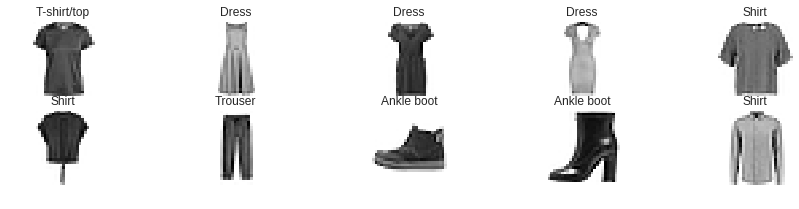

In [7]:
# run this cell multiple time to see random images

indices = random.sample(range(100), 10)

fig = plt.figure(figsize=(15, 3))
for i, ix in enumerate(indices):
  plt.subplot(2, 5, i+1)
  image = trainset.train_data[ix].numpy()
  plt.imshow(image)
  label = label_dict[trainset.train_labels[ix].item()]
  plt.title(label)
  plt.axis('off')

# Define train and test functions

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    # set train mode
    model.train()
    losses = []
    correct = 0.
    
    # loop over the train loader (this is one epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        # get the data and labels and pass them to GPU
        data, target = data.reshape(-1, 28*28).to(device), target.to(device)
        # set stored gradients to 0
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # compute the loss
        loss = criterion(output, target)
        # backward pass: gradient computations
        loss.backward()
        # weight update using an optimizer
        optimizer.step()
        # store metrics
        losses.append(loss.item())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss = np.mean(losses)
    train_acc = correct / len(train_loader.dataset)
    
    # return train loss and train accuracy
    return train_loss, train_acc

In [0]:
def test(model, device, test_loader, epoch):
    # set evaluation mode
    model.eval()
    losses = []
    accuracies = []
    correct = 0
    accuracies = []
    # no gradient will be calculated, so we specify this
    with torch.no_grad():
        # we loop over the test data loader
        for data, target in test_loader:
            # get the data and labels and pass them to GPU
            data, target = data.reshape(-1, 28*28).to(device), target.to(device)
            # forward pass
            output = model(data)
            # loss computations
            losses.append(criterion(output, target).item())
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    # return metrics 
    test_loss = np.mean(losses) 
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [0]:
def plot_history(history, model_name):
    train_loss, train_acc = history['train_loss'], history['train_acc']
    val_loss, val_acc = history['val_loss'], history['val_acc']
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.grid(True)
    plt.title('train & val losses - model : {}'.format(model_name))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(val_acc, label='val acc')
    plt.grid(True)
    plt.title('train & val accuracies - model : {}'.format(model_name))
    plt.legend()
    plt.show()

# First model

In [0]:
# we define a network by inheritating the class nn
# two important things to do:
# specifiy the constructor ==> architecuture
# write the forward pass.


class Net0(nn.Module):
  def __init__(self):
    super(Net0, self).__init__()
    self.fc1 = nn.Linear(28*28, 728)
    self.fc2 = nn.Linear(728, 10)
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [0]:
# prepare train/test loaders

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

In [0]:
# instantiate the network
net = Net0()
# pass it to GPU
net = net.to(device)

# set the otimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# set the loss
criterion = nn.CrossEntropyLoss()

In [0]:
# set the number of epochs

epochs = 5


# store historic KPIs
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# training loop
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(net, device, trainloader, optimizer, epoch)
    val_loss, val_acc = test(net, device, testloader, epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print('[Epoch: {} / {}]\ttrain_loss: {:.4f} \ttrain_acc: {:.4f} \tval_loss: {:.4f} \tval_acc: {:.4f}'.
          format(epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))



 20%|██        | 1/5 [00:17<01:10, 17.55s/it]

[Epoch: 1 / 5]	train_loss: 0.3449 	train_acc: 0.8750 	val_loss: 0.3710 	val_acc: 0.8676



 40%|████      | 2/5 [00:35<00:52, 17.64s/it]

[Epoch: 2 / 5]	train_loss: 0.3219 	train_acc: 0.8825 	val_loss: 0.3650 	val_acc: 0.8696



 60%|██████    | 3/5 [00:53<00:35, 17.66s/it]

[Epoch: 3 / 5]	train_loss: 0.3042 	train_acc: 0.8882 	val_loss: 0.3678 	val_acc: 0.8680



 80%|████████  | 4/5 [01:11<00:17, 17.77s/it]

[Epoch: 4 / 5]	train_loss: 0.2916 	train_acc: 0.8929 	val_loss: 0.3567 	val_acc: 0.8724



100%|██████████| 5/5 [01:29<00:00, 17.87s/it]


[Epoch: 5 / 5]	train_loss: 0.2791 	train_acc: 0.8977 	val_loss: 0.3352 	val_acc: 0.8786


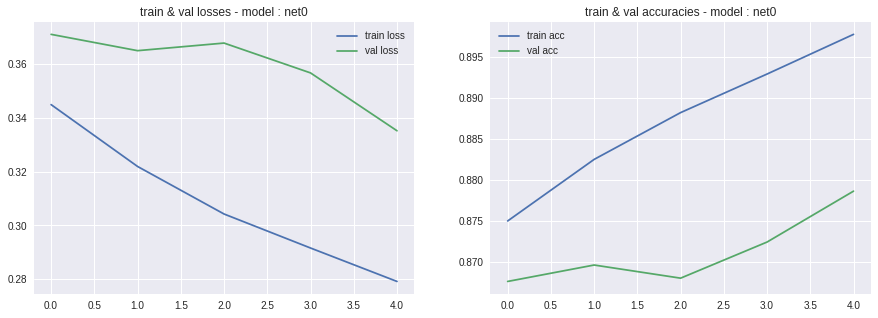

In [0]:
plot_history(history, 'net0')

# Adding L2 regularization

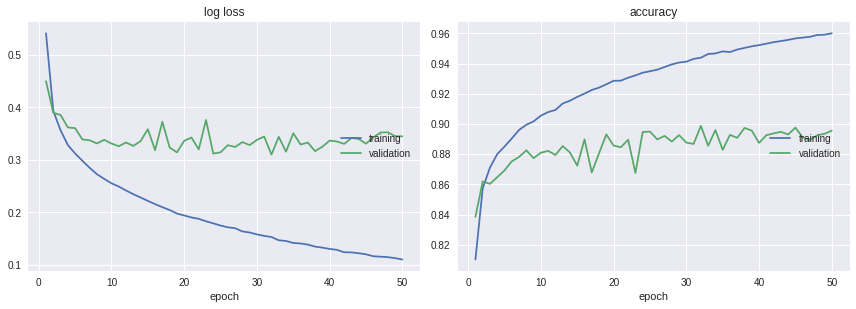

100%|██████████| 50/50 [14:39<00:00, 17.59s/it]


In [0]:
liveloss = PlotLosses()

class Net0(nn.Module):
  def __init__(self):
    super(Net0, self).__init__()
    self.fc1 = nn.Linear(28*28, 728)
    self.fc2 = nn.Linear(728, 10)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    x = self.fc2(x)
    return x


batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

net = Net0().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00005)
criterion = nn.CrossEntropyLoss()

epochs = 50

l2_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(net, device, trainloader, optimizer, epoch)
    val_loss, val_acc = test(net, device, testloader, epoch)
    l2_history['train_loss'].append(train_loss)
    l2_history['val_loss'].append(val_loss)
    l2_history['train_acc'].append(train_acc)
    l2_history['val_acc'].append(val_acc)
    print('[Epoch: {} / {}]\ttrain_loss: {:.4f} \ttrain_acc: {:.4f} \tval_loss: {:.4f} \tval_acc: {:.4f}'.
          format(epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

    liveloss.update({
        'log loss': train_loss,
        'val_log loss': val_loss,
        'accuracy': train_acc,
        'val_accuracy': val_acc
    })
    liveloss.draw()

In [0]:
utils.plot_history(l2_history, 'l2')